# Predicción de Fallas en Dispositivos - Mantenimiento Predictivo

## Objetivo
Desarrollar un modelo predictivo para predecir la probabilidad de falla de dispositivos en galpones de Full de Mercado Libre, con el objetivo de optimizar los costos de mantenimiento.

## Estructura de Costos
- **Costo de falla**: 1.0
- **Costo de mantenimiento preventivo**: 0.5

## Matriz de Costos
| Predicción | Real: Falla | Real: No Falla |
|------------|-------------|----------------|
| Falla (Mantenimiento) | 0.5 (evitamos falla) | 0.5 (mantenimiento innecesario) |
| No Falla | 1.0 (falla no prevenida) | 0.0 (óptimo) |

**Insight clave**: Los falsos negativos (no predecir una falla) son más costosos que los falsos positivos (mantenimiento innecesario).

## Interpretación de Métricas en este Problema

**Clase positiva (1) = Falla** | **Clase negativa (0) = No falla**

| Métrica | Fórmula | ¿Qué significa aquí? |
|---------|---------|----------------------|
| **Recall** | TP / (TP + FN) | % de fallas reales que detectamos. **Prioridad alta**: FN cuesta $1.0 |
| **Precision** | TP / (TP + FP) | % de alertas de falla que fueron correctas. FP cuesta $0.5 |
| **F1-Score** | 2 × (P × R) / (P + R) | Balance entre ambas |

> **En este problema priorizamos Recall** porque no detectar una falla (FN=$1.0) cuesta el doble que un mantenimiento innecesario (FP=$0.5).

In [1]:
# Importación de librerías y utilidades
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from utils_classifier import (
    # Constantes
    COST_FAILURE, COST_MAINTENANCE, ATTRIBUTES,
    # Clases principales
    FeatureEngineer, DataPreparator, ModelTrainer, OptunaOptimizer, Visualizer,
    # Funciones
    calculate_cost, calculate_baseline_cost, optimize_threshold,
    save_model_artifacts, predict_failure_probability,
    # Funciones de análisis
    analyze_dataset, analyze_nulls, analyze_target_distribution, plot_cost_over_time,
    plot_cost_over_time_with_model,
    analyze_temporal, analyze_baseline_costs, analyze_split, analyze_smote,
    analyze_threshold_optimization, analyze_final_model, print_executive_summary,
    analyze_mean_comparison, analyze_correlation, analyze_device_failures,
    select_best_boost_model, analyze_optimized_model_performance,
    analyze_attribute_distributions, analyze_feature_engineering_results, train_baseline_model,
    train_models_pipeline, run_optuna_optimization, run_threshold_optimization,
    evaluate_final_model_performance
)

pd.set_option('display.max_columns', None)
print("✅ Librerías importadas")

✅ Librerías importadas


---
## 1. Carga y Exploración Inicial de Datos

In [2]:
# Cargar datos (encoding_errors='replace' para manejar bytes inválidos en el CSV)
df = pd.read_csv('full_devices.csv', encoding_errors='replace')
analyze_dataset(df)
df.head(10)


INFORMACIÓN GENERAL DEL DATASET

Dimensiones: 124,494 filas x 12 columnas

Columnas: ['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

Tipos de datos:
date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
5,2015-01-01,S1F01TD5,0,68837488,0,0,41,6,413535,0,0,1
6,2015-01-01,S1F01XDJ,0,227721632,0,0,0,8,402525,0,0,0
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3
8,2015-01-01,S1F02A0J,0,8217840,0,1,0,14,311869,0,0,0
9,2015-01-01,S1F02DZ2,0,116440096,0,323,9,9,407905,0,0,164


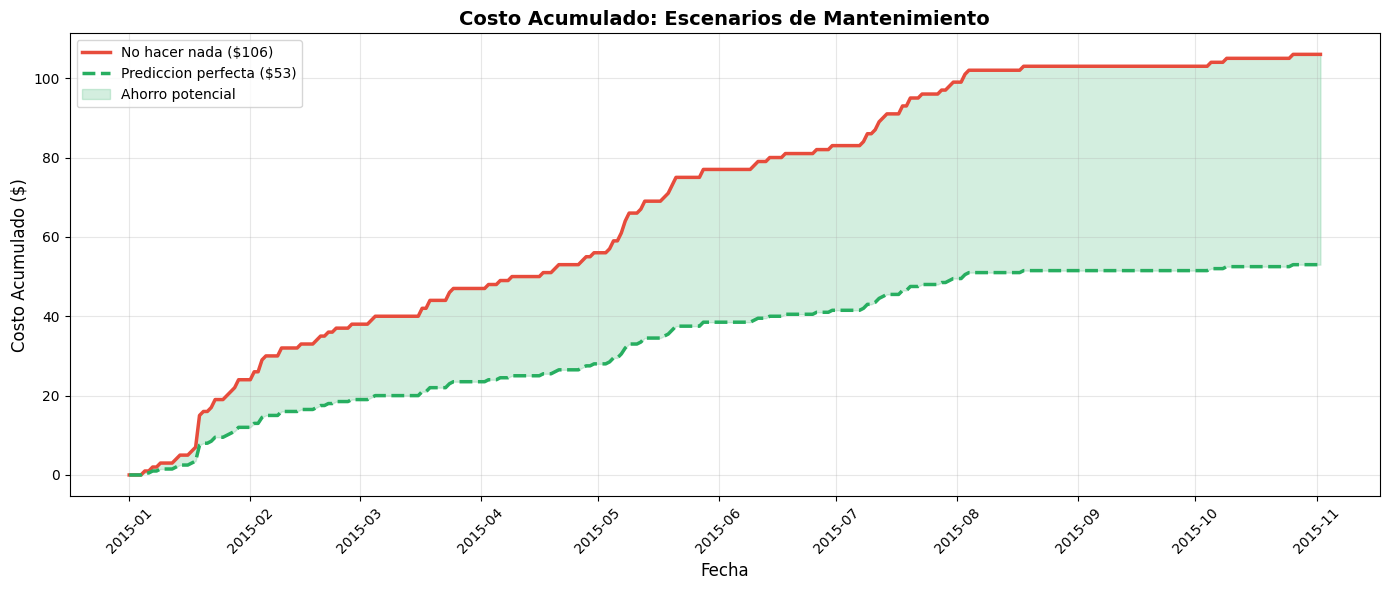


RESUMEN DE COSTOS
Total de registros: 124,494
Total de fallas: 106 (0.09%)

Escenarios:
  1. No hacer nada:        $106.00
  2. Prediccion perfecta:  $53.00

Ahorro maximo posible: $53.00 (50.0%)


In [3]:
# Visualización de costos a lo largo del tiempo
# Comparación de escenarios: no hacer nada vs predicción perfecta
plot_cost_over_time(df)

In [4]:
# Convertir fecha
df['date'] = pd.to_datetime(df['date'])
# Análisis de valores nulos
analyze_nulls(df)


ANÁLISIS DE VALORES NULOS
No hay valores nulos en el dataset



DISTRIBUCIÓN DE LA VARIABLE OBJETIVO

Conteo:
  - No falla (0): 124,388 (99.91%)
  - Falla (1):    106 (0.09%)

Ratio de desbalance: 1:1173

⚠️  DATASET DESBALANCEADO - Se requieren técnicas de balanceo


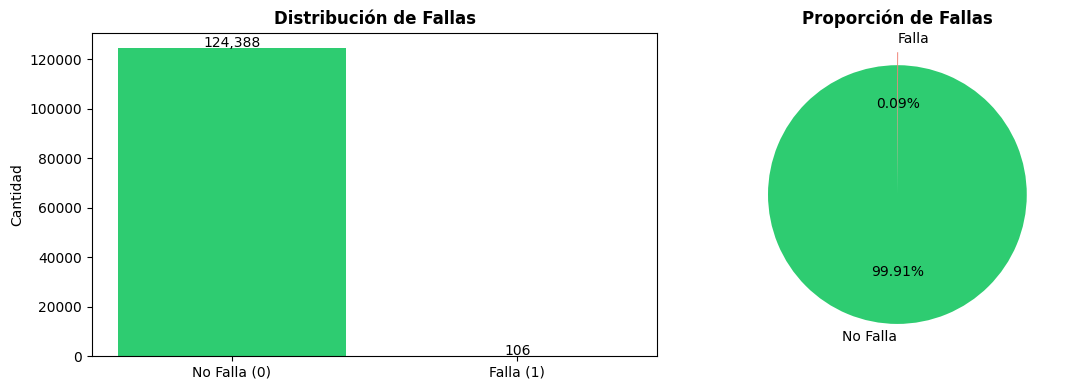

In [5]:
# Análisis de la variable objetivo
analyze_target_distribution(df)
Visualizer.plot_failure_distribution(df)

---
## 2. Análisis Exploratorio de Datos (EDA)

In [6]:
# Análisis temporal
analyze_temporal(df)


ANÁLISIS TEMPORAL

Rango de fechas: 2015-01-01 00:00:00 a 2015-11-02 00:00:00
Duración total: 305 días
Dispositivos únicos: 1,169



DISTRIBUCIÓN DE ATRIBUTOS


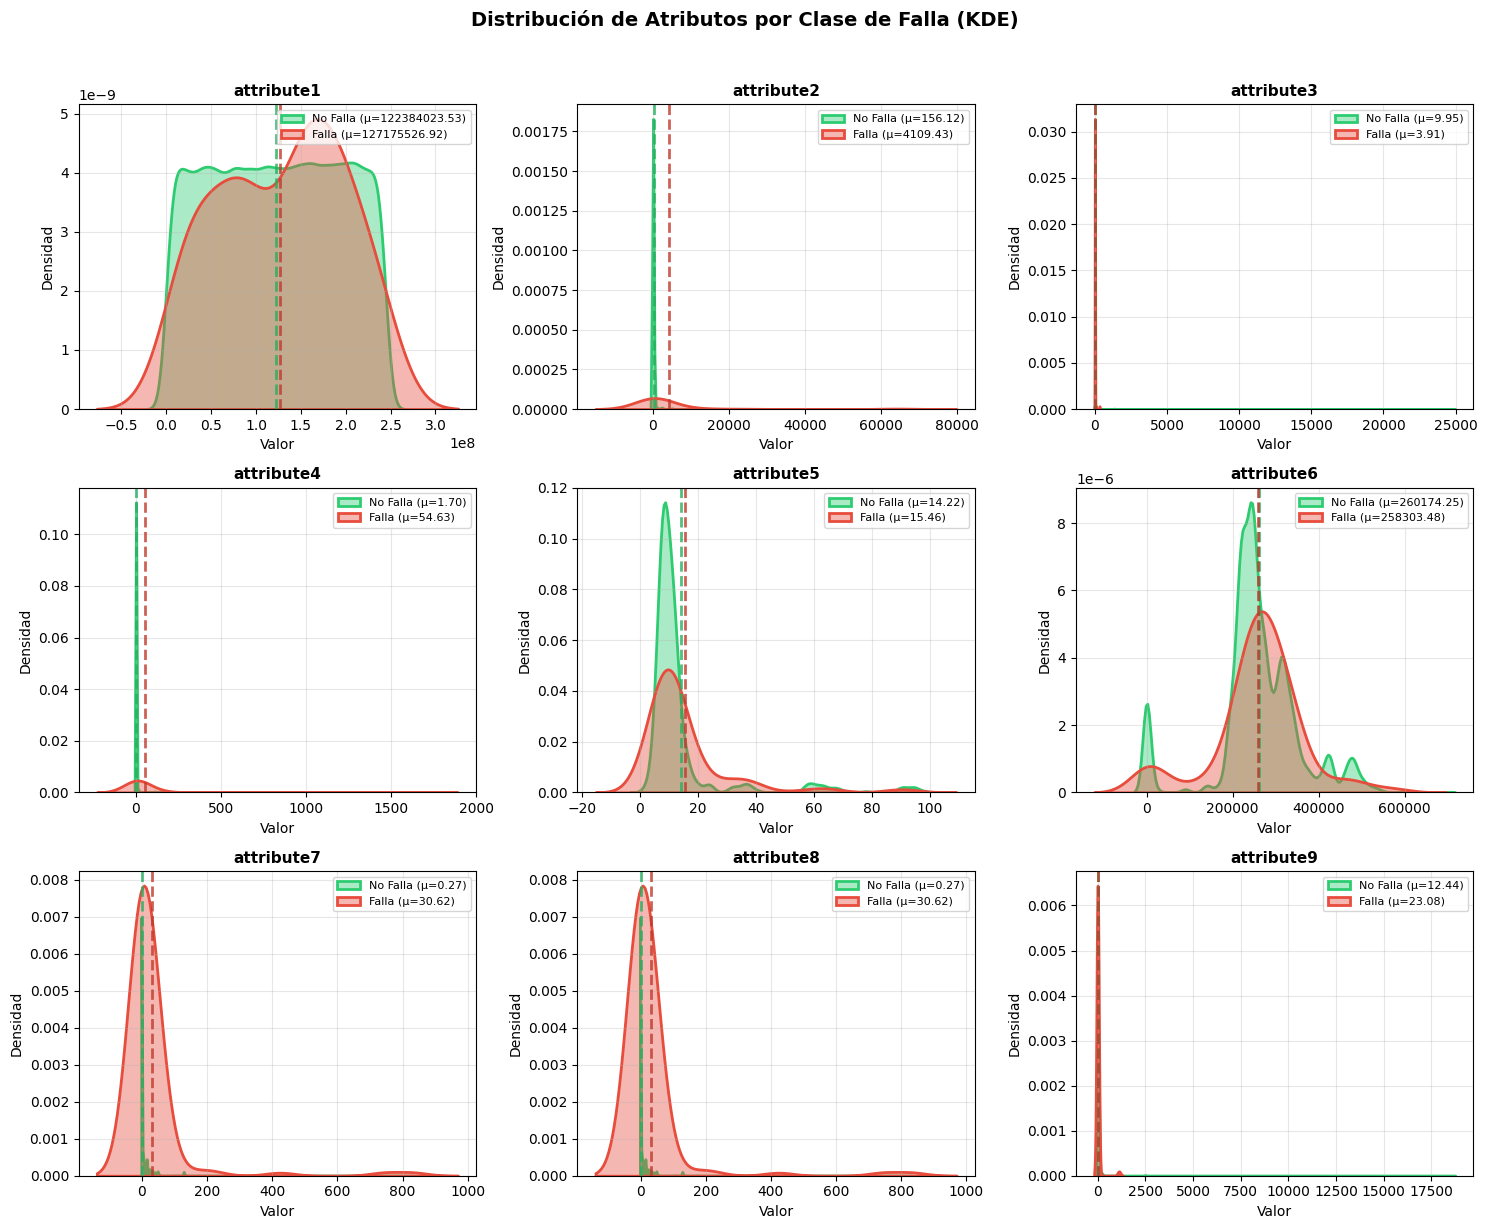

In [7]:
# Distribución de atributos
attributes = [f'attribute{i}' for i in range(1, 10)]
analyze_attribute_distributions(df, attributes)


MATRIZ DE CORRELACIÓN


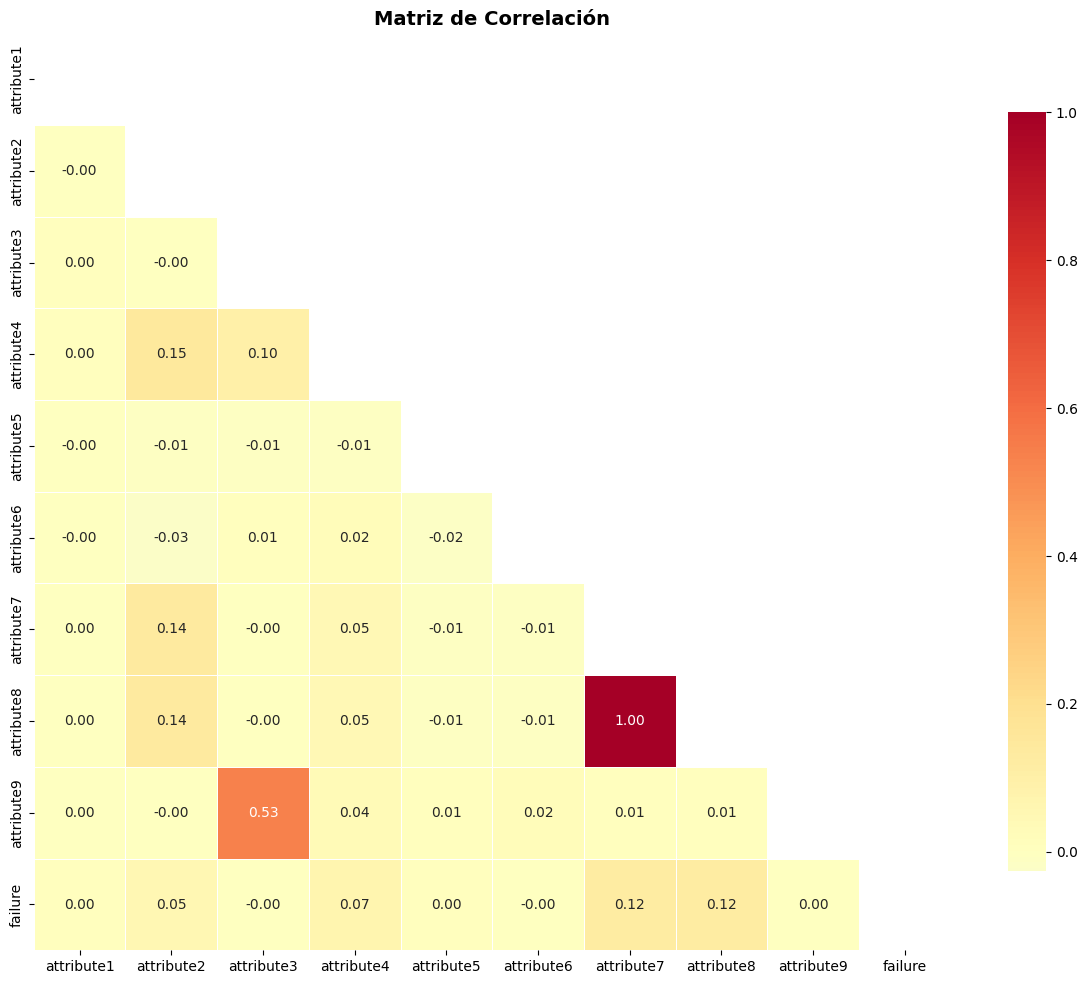


Correlación con 'failure':
attribute7    0.119055
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute3   -0.000948
attribute6   -0.000550
Name: failure, dtype: float64


In [8]:
# Matriz de correlación
analyze_correlation(df, attributes)

In [9]:
# Análisis por dispositivo
analyze_device_failures(df)


ANÁLISIS POR DISPOSITIVO

Dispositivos con al menos una falla: 106
Dispositivos sin fallas: 1063

Top 10 dispositivos con más fallas:
          total_fallas  dias_operacion  tasa_falla
device                                            
S1F023H2             1              19    5.263158
S1F03YZM             1             215    0.465116
S1F09DZQ             1             199    0.502513
S1F0CTDN             1               7   14.285714
S1F0DSTY             1              45    2.222222
S1F0F4EB             1             127    0.787402
S1F0GG8X             1              18    5.555556
S1F0GJW3             1              76    1.315789
S1F0GKFX             1             117    0.854701
S1F0GKL6             1             133    0.751880


---
## 3. Modelo Baseline (Sin Feature Engineering)

Antes de crear features adicionales, evaluamos qué tan bien predicen las **9 features originales** (attribute1-9).

Esto establece un **punto de comparación** para medir el valor agregado del feature engineering.

| Modelo | Descripción |
|--------|-------------|
| Logistic Regression | Modelo lineal simple, rápido |
| Random Forest | Ensemble de árboles, captura no-linealidades |
| Gradient Boosting | Boosting secuencial, generalmente mejor rendimiento |

In [10]:
# Entrenar modelo baseline con las 9 features originales
# Usamos SMOTE para que la comparación con los modelos de feature engineering sea justa
baseline_results = train_baseline_model(df, feature_cols=ATTRIBUTES, use_smote=True)

# Guardar el mejor F1 para comparar después del feature engineering
baseline_best_f1 = baseline_results['best_model']['f1']
baseline_best_cost = baseline_results['best_model']['cost']
print(f"\n>>> Guardar para comparar: F1={baseline_best_f1:.4f}, Costo=${baseline_best_cost:,.0f}")


MODELO BASELINE (Features Originales - con SMOTE)

Features utilizadas (9): ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']

Split de datos:
  Train: 99,595 (80.0%)
  Test:  24,899 (20.0%)
  Fallas en train: 83 (0.08%)
  Fallas en test:  23 (0.09%)

SMOTE aplicado:
  Antes: 99,595 muestras (83 fallas)
  Después: 129,365 muestras (29,853 fallas)

Modelo                       AUC-ROC  Precision     Recall         F1        Costo
Logistic Regression           0.8138     0.0105     0.4783     0.0206 $       534
Random Forest                 0.8220     0.0175     0.1739     0.0317 $       134
Gradient Boosting             0.9298     0.0212     0.2609     0.0392 $       158
Baseline (no hacer nada)           -          -          -          - $        23
Optimo (pred. perfecta)            -          -          -          - $        12

MEJOR MODELO BASELINE: Gradient Boosting (por F1)
  F1-Score: 0.0392
  Recall:

---
## 4. Feature Engineering

A partir de los 9 atributos originales, generamos features para capturar patrones temporales y comportamientos anómalos:

| Tipo de Feature | Descripción | Ejemplo |
|-----------------|-------------|---------|
| **Temporales** | Características del calendario (día, mes, semana) con encoding cíclico para capturar estacionalidad | `day_of_week_sin`, `month_cos`, `is_weekend` |
| **Rolling Stats** | Estadísticas móviles (media, max) en ventanas de 3, 7, 14 días para suavizar ruido | `attribute1_rolling_mean_7`, `attribute2_rolling_max_14` |
| **Diferencias** | Cambio absoluto y porcentual respecto al día anterior para detectar cambios bruscos | `attribute1_diff`, `attribute5_pct_change` |
| **Z-Score (Anomalías)** | Desviación estándar respecto a la media móvil de 7 días | `attribute1_zscore_7` |
| **Agregados por Dispositivo** | Estadísticas históricas de cada dispositivo (media, std, max, min global) | `attribute1_device_mean`, `attribute3_device_max` |
| **Antigüedad** | Días desde el primer registro del dispositivo | `device_age_days` |
| **Prefijo del Dispositivo** | One-hot encoding del prefijo (tipo de dispositivo) | `prefix_S1F`, `prefix_W1F` |
| **Interacciones** | Combinaciones entre atributos | `sum_all_attributes`, `mean_all_attributes` |

**Intuición:** Un dispositivo que muestra valores anómalos en múltiples atributos, con cambios bruscos recientes y desviaciones de su comportamiento histórico, tiene mayor probabilidad de falla.

In [11]:
# Feature Engineering usando la clase FeatureEngineer
print("Creando features con FeatureEngineer...")

feature_engineer = FeatureEngineer()
df = feature_engineer.fit_transform(df)

print(f"✓ Feature engineering completado")
print(f"Total de columnas: {df.shape[1]}")

# Verificar valores nulos generados por lag/rolling y resumen de features
analyze_feature_engineering_results(df)

Creando features con FeatureEngineer...
✓ Feature engineering completado
Total de columnas: 153

┌─────────────────────────────────────────────────────────┐
│           FEATURE ENGINEERING - RESUMEN                 │
├─────────────────────────────────────────────────────────┤
│  Dimensiones: 124,494 filas × 153 columnas               │
│  Nulos: 63 cols con NaN (0.4% del total)                     │
├─────────────────────────────────────────────────────────┤
│  Features generadas:                                    │
│    • Rolling (mean, max):         54 features           │
│    • Diferencias/Cambios:         18 features           │
│    • Z-Score (anomalías):          9 features           │
│    • Temporales:                   6 features           │
│    • Dispositivo:                  8 features           │
│    • Agregados por device:        36 features           │
│    • Interacciones:                9 features           │
└────────────────────────────────────────────────────────

### ¿Por qué SMOTE y no ajustar pesos?

Se realizó un análisis comparativo entre usar **SMOTE** vs **ajustar `scale_pos_weight`** en LightGBM para manejar el desbalance de clases (ratio 1:1173).

**Resultados de la comparación:**

| Modelo | TP | FN | FP | Recall | Precision | F1 | Costo |
|--------|----|----|-----|--------|-----------|-----|-------|
| Baseline (sin pesos) | 0 | 21 | 0 | 0.0% | 0.0% | 0.0000 | $21.0 |
| **SMOTE** | **2** | 19 | 26 | **9.5%** | 7.1% | **0.0816** | $33.0 |
| Peso 1:10 | 1 | 20 | 8 | 4.8% | 11.1% | 0.0667 | $24.5 |
| Peso 1:50 | 2 | 19 | 34 | 9.5% | 5.6% | 0.0702 | $37.0 |
| Peso 1:100 | 2 | 19 | 36 | 9.5% | 5.3% | 0.0678 | $38.0 |
| Peso 1:500 | 2 | 19 | 56 | 9.5% | 3.4% | 0.0506 | $48.0 |

**Conclusiones:**

1. **SMOTE obtiene el mejor F1-Score (0.0816)** y el mejor balance entre detectar fallas y minimizar falsas alarmas.

2. **Ajustar pesos genera más falsas alarmas**: A mayor peso, más FP sin mejorar el recall. Por ejemplo, peso 1:500 tiene 56 falsas alarmas vs 26 de SMOTE, detectando la misma cantidad de fallas.

3. **SMOTE genera datos sintéticos** que ayudan al modelo a aprender mejor los patrones de la clase minoritaria, en lugar de simplemente penalizar más los errores en esa clase.

4. **El baseline sin ajustes es inútil**: Predice todo como "no falla" (0 TP) porque la clase minoritaria es tan rara que el modelo la ignora.

**Por estas razones, se eligió SMOTE como estrategia de balanceo.**

In [12]:
# Verificar valores nulos generados por lag/rolling y resumen de features
analyze_feature_engineering_results(df)


┌─────────────────────────────────────────────────────────┐
│           FEATURE ENGINEERING - RESUMEN                 │
├─────────────────────────────────────────────────────────┤
│  Dimensiones: 124,494 filas × 153 columnas               │
│  Nulos: 63 cols con NaN (0.4% del total)                     │
├─────────────────────────────────────────────────────────┤
│  Features generadas:                                    │
│    • Rolling (mean, max):         54 features           │
│    • Diferencias/Cambios:         18 features           │
│    • Z-Score (anomalías):          9 features           │
│    • Temporales:                   6 features           │
│    • Dispositivo:                  8 features           │
│    • Agregados por device:        36 features           │
│    • Interacciones:                9 features           │
└─────────────────────────────────────────────────────────┘



---
## 4. Preparación de Datos para Modelado

In [13]:
# Preparación de datos usando DataPreparator
data_prep = DataPreparator()
X, y, df_model = data_prep.prepare_features(df)

print(f"Filas originales: {df.shape[0]:,}")
print(f"Filas después de limpieza: {len(X):,}")
print(f"Features: {len(data_prep.feature_cols)}")

Filas dropeadas (NaN): 2,337 (1.9%)
Filas restantes: 122,157 (98.1%)
Filas originales: 124,494
Filas después de limpieza: 122,157
Features: 150


In [14]:
# Distribución del target
print(f"Muestras: {len(X):,}, Features: {len(data_prep.feature_cols)}")

# Imputar valores nulos
X_imputed = data_prep.fit_transform_imputer(X)
print("✓ Valores nulos e infinitos tratados")

# Selección de features por importancia (elimina features que no aportan)
X_selected, selected_features, importance_df = data_prep.select_features_by_importance(
    X_imputed, y, 
    importance_threshold=0.001  # Elimina features con importancia < 0.1%
)

# Mostrar top features
print("\n📊 TOP 10 features más importantes:")
print(importance_df.head(10).to_string(index=False))

# Split temporal (usar X_selected en lugar de X_imputed)
X_train, X_test, y_train, y_test, split_date = data_prep.temporal_split(X_selected, y, df_model)
analyze_split(X_train, X_test, y_train, y_test, split_date)

# Escalar features
X_train_scaled = data_prep.fit_transform_scaler(X_train)
X_test_scaled = data_prep.transform_scaler(X_test)
print("✓ Features escaladas con RobustScaler")

Muestras: 122,157, Features: 150
✓ Valores nulos e infinitos tratados

🔍 Selección de features por importancia...
   Umbral de importancia: 0.001
   Features originales: 150
   Features seleccionadas: 132
   Features eliminadas: 18

   ❌ Features eliminadas (baja importancia):
      - attribute3_rolling_mean_3: 0.000241
      - attribute3_rolling_max_3: 0.000561
      - attribute3_rolling_mean_7: 0.000716
      - attribute3_rolling_max_7: 0.000507
      - attribute3_diff: 0.000000
      - attribute3_pct_change: 0.000000
      - attribute9_diff: 0.000000
      - attribute9_pct_change: 0.000000
      - attribute3_zscore_7: 0.000424
      - attribute3_device_max: 0.000676
      - attribute3_device_min: 0.000975
      - attribute7_device_min: 0.000354
      - device_failures_so_far: 0.000000
      - device_failure_rate_so_far: 0.000000
      - device_has_failed_before: 0.000000
      - prefix_Z1F: 0.000178
      - min_all_attributes: 0.000067
      - attr7_attr8_equal: 0.000000

📊 TOP 10 f

---
## 5. Función de Costo Personalizada

In [15]:
# Análisis de costos baseline
baseline_cost = analyze_baseline_costs(y_test)


ANÁLISIS DE COSTOS BASELINE

┌─────────────────────────────────────────────────────────────────────┐
│                        MATRIZ DE COSTOS                             │
├─────────────────────────────────────────────────────────────────────┤
│                    │ Predicho: No Falla │ Predicho: Falla           │
├────────────────────┼────────────────────┼───────────────────────────┤
│ Real: No Falla     │ TN = $0 (óptimo)   │ FP = $0.5 (mant. innecesario) │
│ Real: Falla        │ FN = $1.0 (no prevenida)│ TP = $0.5 (mant. previene)    │
└─────────────────────────────────────────────────────────────────────┘

📊 ESCENARIOS DE COSTO (Test: 24,588 muestras, 23 fallas)
------------------------------------------------------------
  1. No hacer nada (todas fallas ocurren):     $23.00
     → 23 FN × $1.0 = $23.00

  2. ÓPTIMO (mantener solo los que fallan):    $11.50
     → 23 TP × $0.5 = $11.50

------------------------------------------------------------
Meta del modelo: acercarse al ópt

---
## 6. Entrenamiento de Modelos

In [16]:
# Crear trainer y aplicar SMOTE
class_weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()
model_trainer = ModelTrainer(class_weight_ratio)
X_train_balanced, y_train_balanced = model_trainer.apply_smote(X_train_scaled, y_train)
analyze_smote(y_train, y_train_balanced)


🔄 Aplicando resampling: SMOTE
   Antes: 97,569 muestras (83 fallas, 0.09%)
   Después: 126,731 muestras (29,245 fallas, 23.08%)

BALANCEO CON SMOTE

Antes: 97,569 muestras
  - No fallas: 97,486
  - Fallas: 83

Después: 126,731 muestras
  - No fallas: 97,486
  - Fallas: 29,245


In [17]:
# Modelos a entrenar
print(f"Ratio de clases: {class_weight_ratio:.2f}")
print(f"Modelos a entrenar: {list(model_trainer.models.keys())}")

Ratio de clases: 1174.53
Modelos a entrenar: ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']


In [18]:
# Entrenar y evaluar modelos
results = train_models_pipeline(
    model_trainer=model_trainer,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    X_test=X_test_scaled,
    y_test=y_test,
    baseline_cost=baseline_cost
)


ENTRENAMIENTO Y EVALUACIÓN DE MODELOS

Entrenando: Logistic Regression
  AUC-ROC: 0.6887, Recall: 0.6522, Ahorro: -16554.35%

Entrenando: Random Forest
  AUC-ROC: 0.8050, Recall: 0.0000, Ahorro: -30.43%

Entrenando: XGBoost
  AUC-ROC: 0.7052, Recall: 0.0870, Ahorro: -308.70%

Entrenando: LightGBM
  AUC-ROC: 0.7070, Recall: 0.2609, Ahorro: -1495.65%

Entrenando: CatBoost
  AUC-ROC: 0.7048, Recall: 0.5652, Ahorro: -14750.00%


In [19]:
# Comparación de modelos
print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

comparison_df = model_trainer.get_comparison_df()
print(comparison_df.to_string(index=False))


COMPARACIÓN DE MODELOS
             Modelo  AUC-ROC  Precision  Recall  F1-Score  Costo Total  Ahorro (%)
      Random Forest   0.8050     0.0000  0.0000    0.0000         30.0    -30.4348
            XGBoost   0.7052     0.0137  0.0870    0.0237         94.0   -308.6957
           LightGBM   0.7070     0.0086  0.2609    0.0166        367.0  -1495.6522
           CatBoost   0.7048     0.0019  0.5652    0.0038       3415.5 -14750.0000
Logistic Regression   0.6887     0.0020  0.6522    0.0039       3830.5 -16554.3478


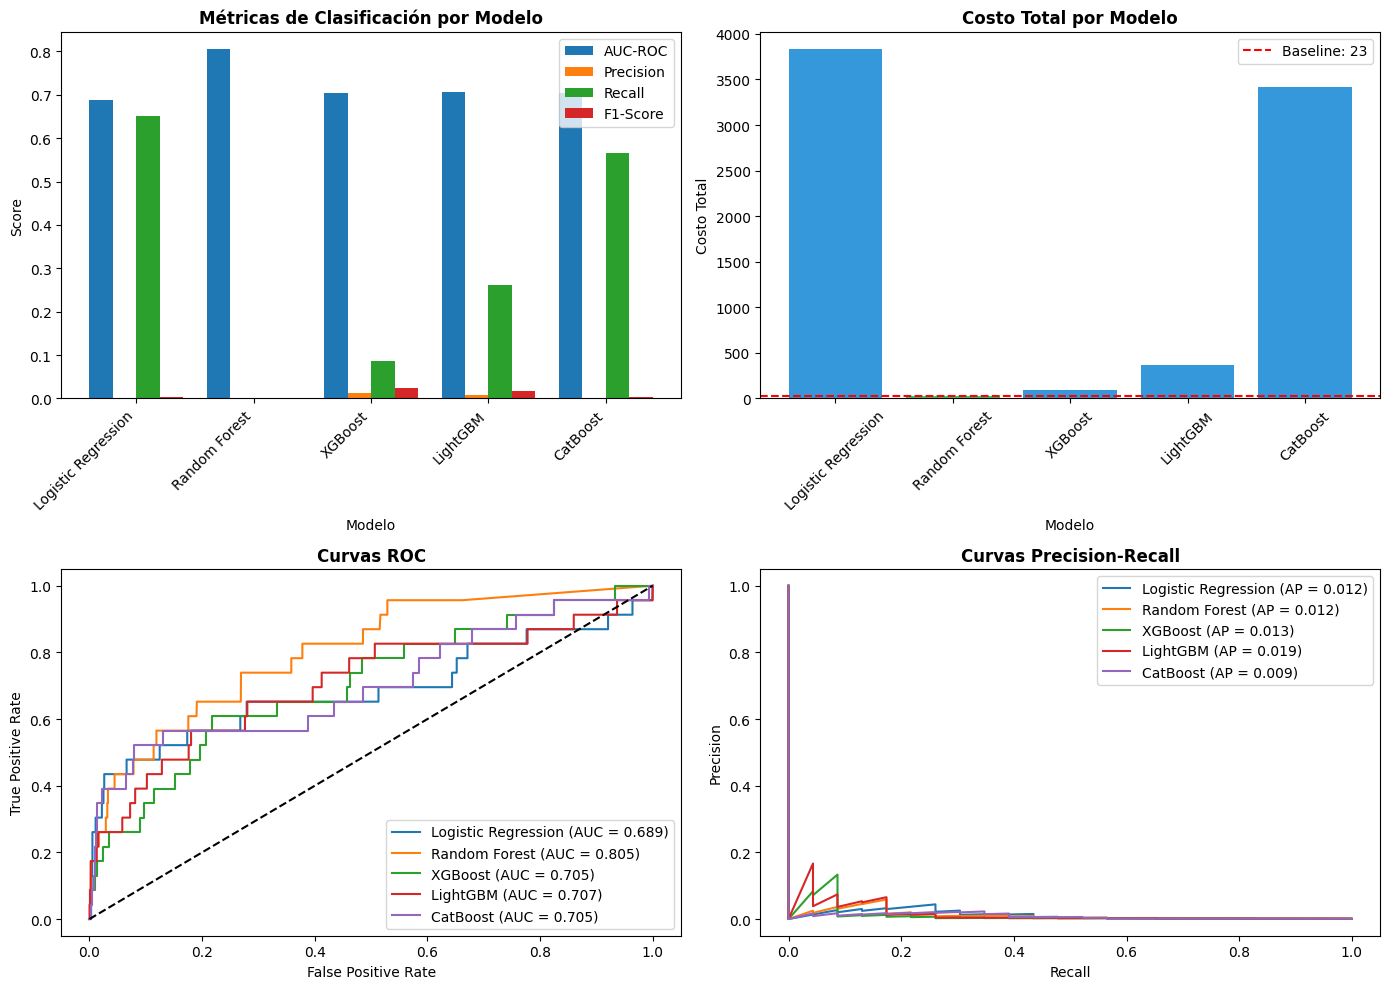

In [20]:
# Visualización de comparación de modelos
Visualizer.plot_model_comparison(results, baseline_cost, y_test)

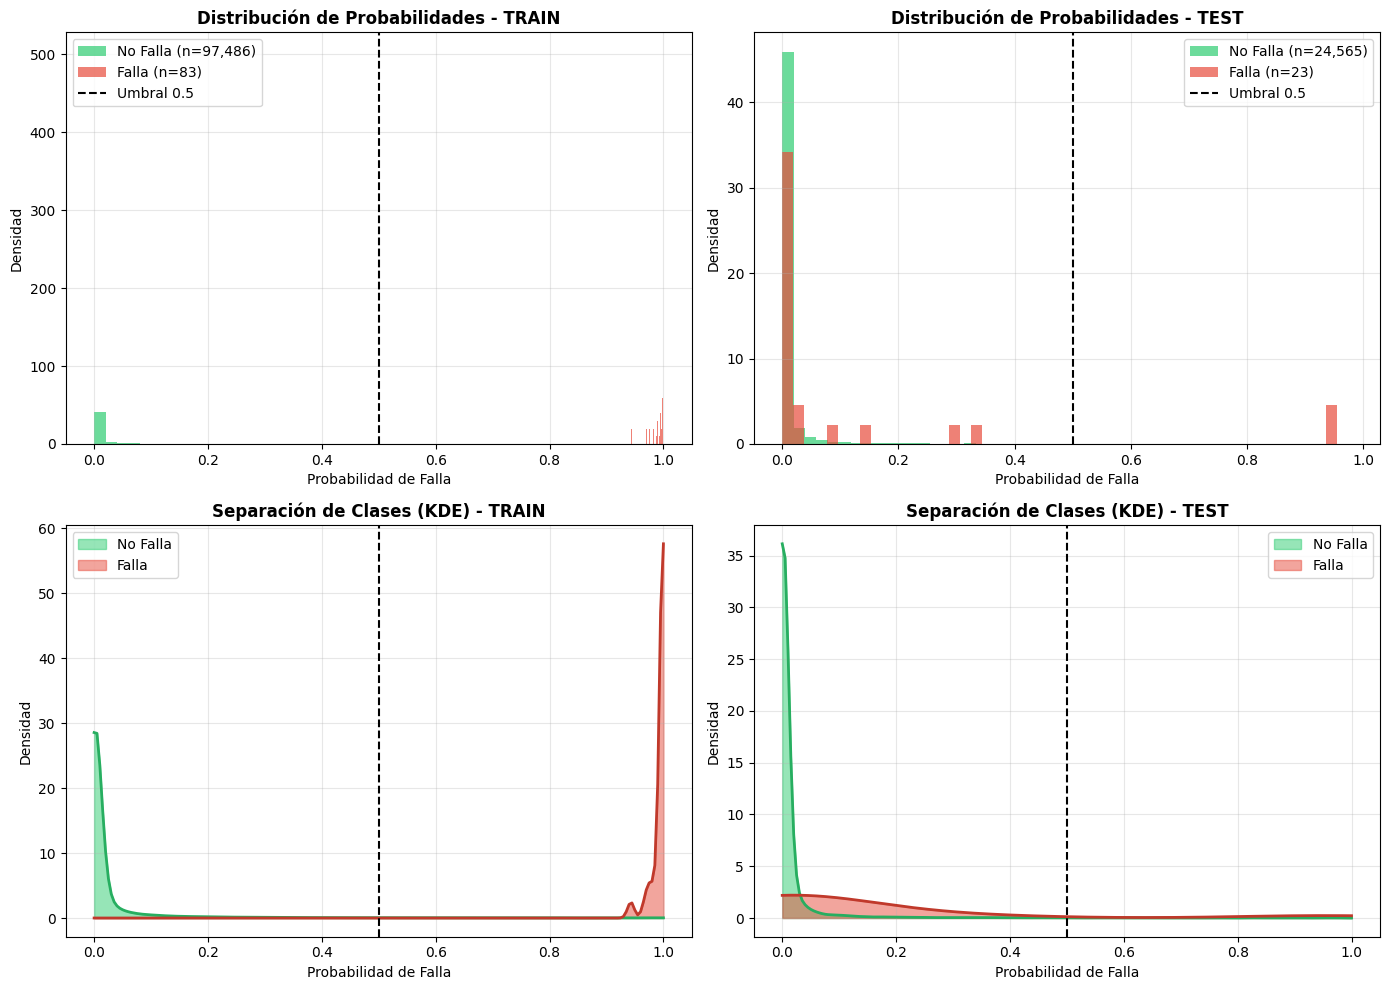


Estadísticas de Separación de Clases:
--------------------------------------------------
TRAIN - No Falla: media=0.0310, std=0.1069
TRAIN - Falla:    media=0.9937, std=0.0127
TEST  - No Falla: media=0.0151, std=0.0696
TEST  - Falla:    media=0.1248, std=0.2705


In [21]:
# Separación de clases en Train vs Test
best_model_name_initial, best_model_initial = model_trainer.get_best_model(metric='f1')
y_train_proba = best_model_initial['model'].predict_proba(X_train_scaled)[:, 1]
Visualizer.plot_class_separation(y_train.values, y_test.values, y_train_proba, best_model_initial['y_pred_proba'])

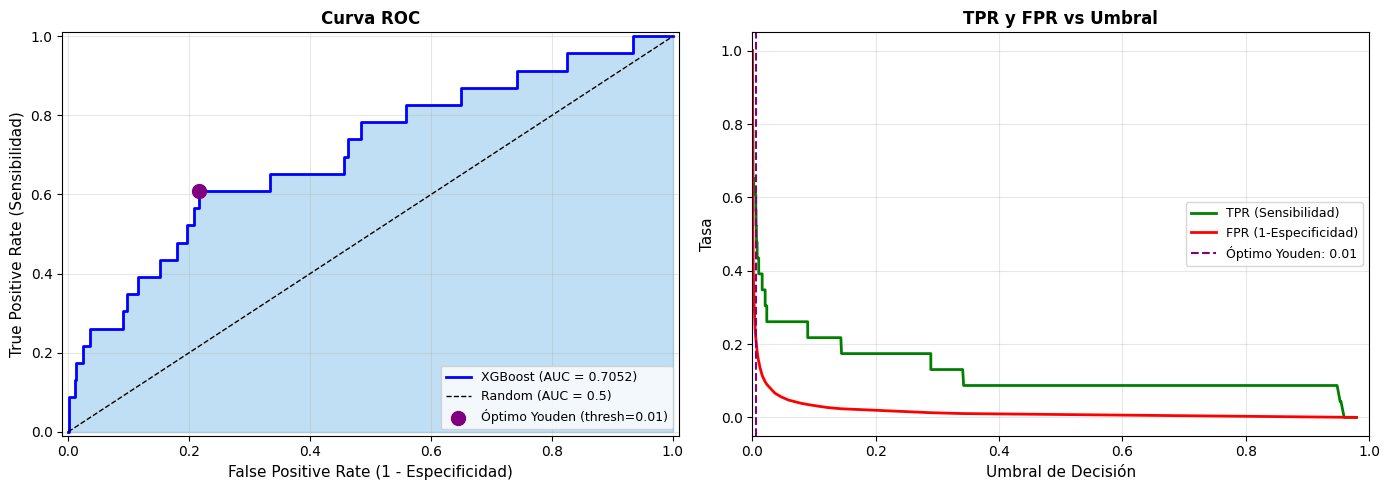


📊 Métricas en umbral óptimo Youden (0.006):
   - TPR (Sensibilidad): 0.6087
   - FPR: 0.2168
   - Especificidad: 0.7832


In [22]:
# Curva ROC detallada
Visualizer.plot_roc_curve_detailed(y_test.values, best_model_initial['y_pred_proba'], best_model_name_initial)

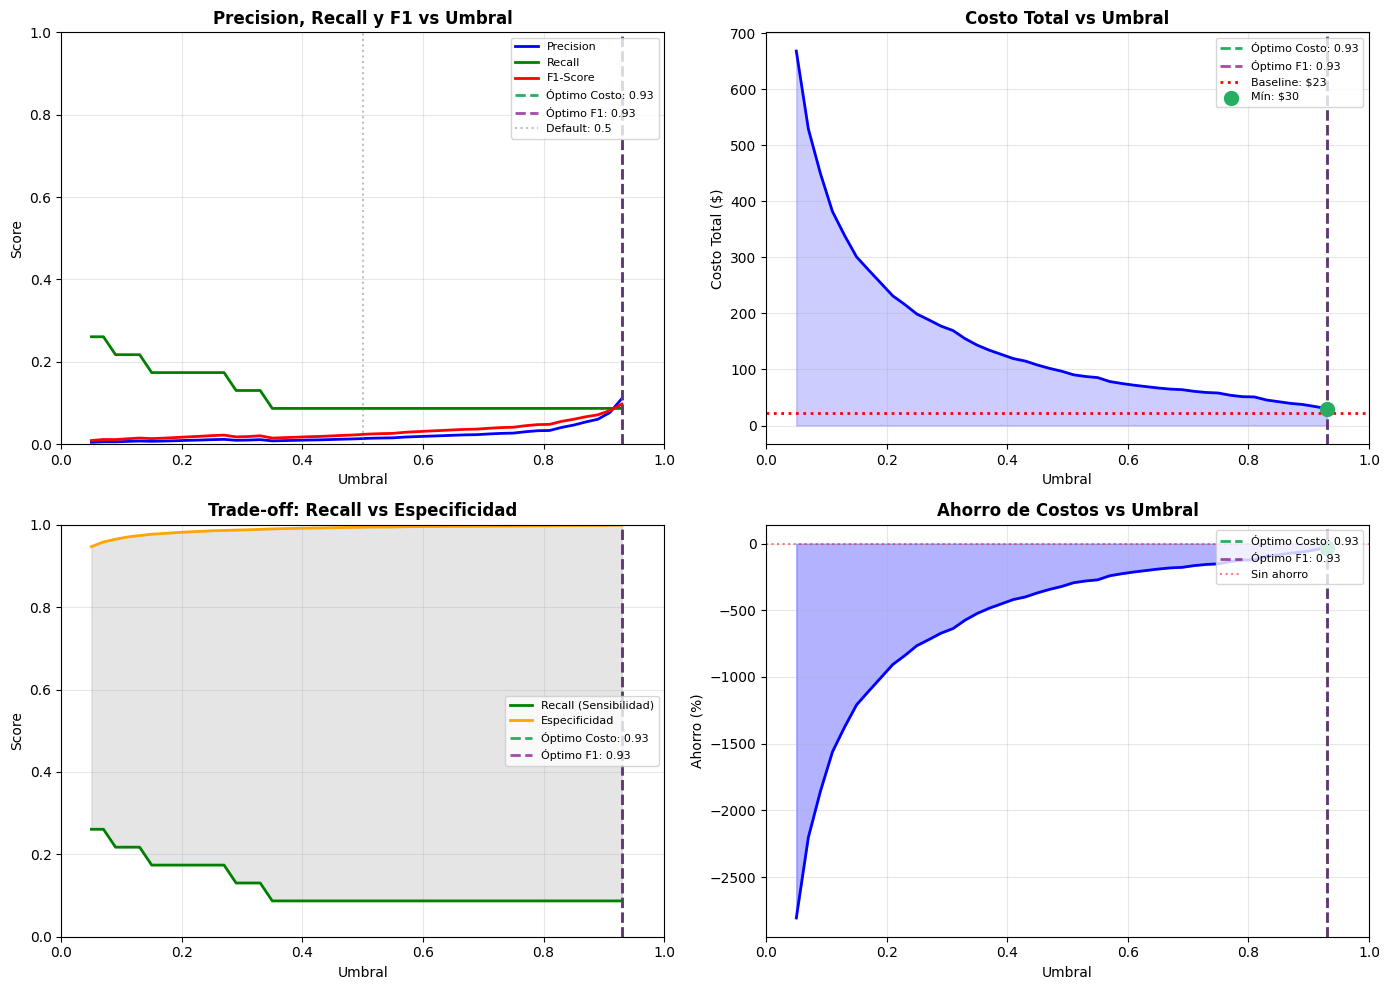


📊 Comparación de Umbrales Óptimos:
   Criterio     Umbral   Costo        Ahorro %   F1       Recall  
   ----------------------------------------------------------
   Por Costo    0.93     $30          -30.4      0.0976   0.0870  
   Por F1       0.93     $30          -30.4      0.0976   0.0870  

   💡 Diferencia de costo: $0 (optimizar por costo ahorra más)


In [23]:
# Métricas vs Threshold
Visualizer.plot_metrics_vs_threshold(y_test.values, best_model_initial['y_pred_proba'], baseline_cost)

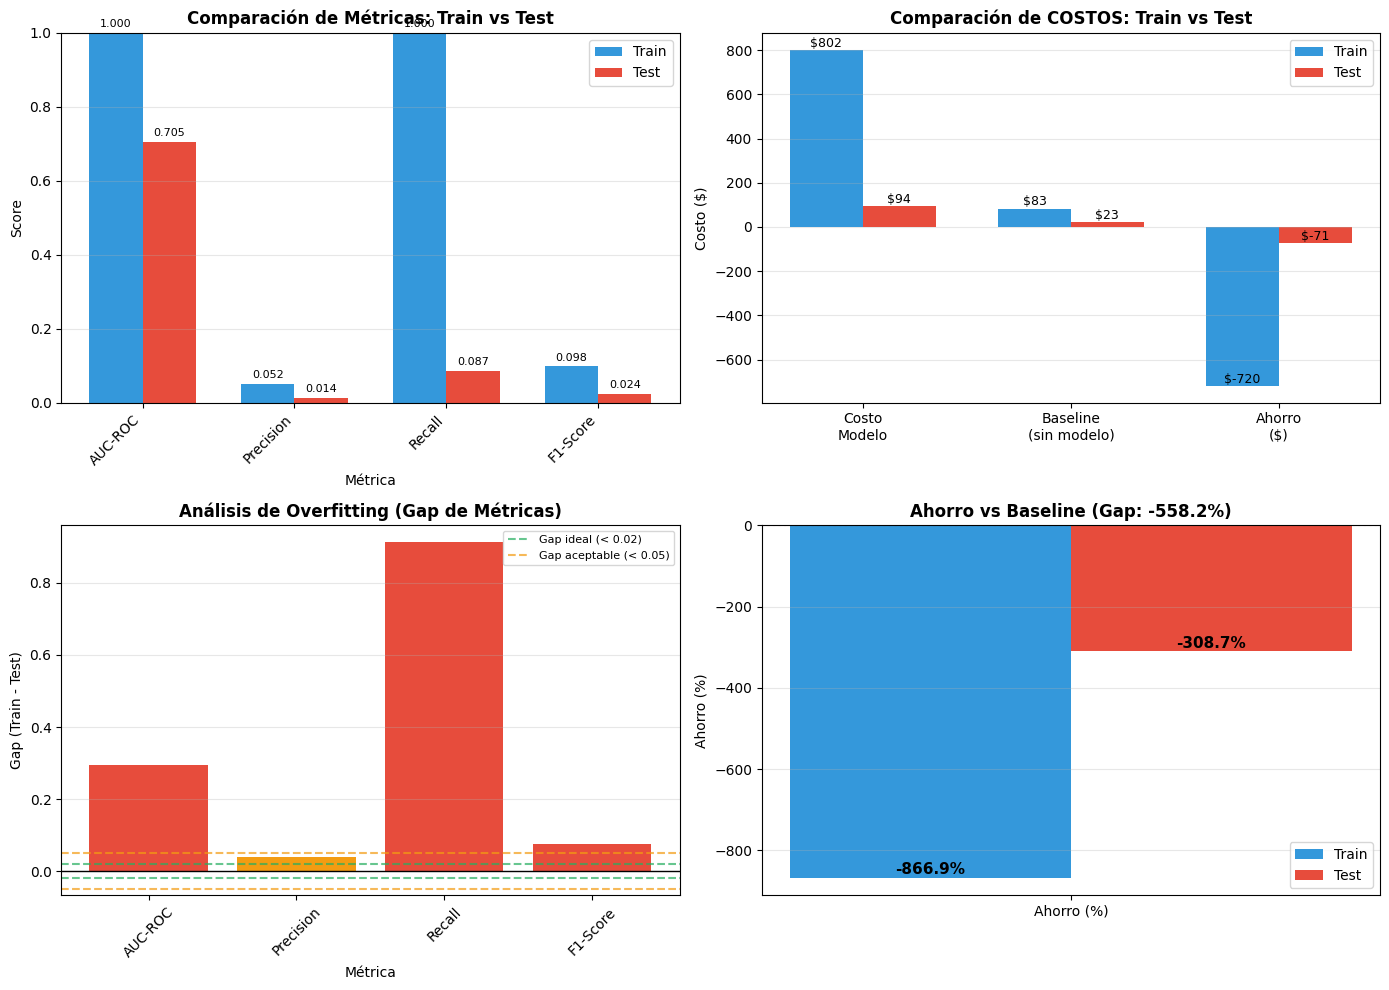


📊 ANÁLISIS DE GENERALIZACIÓN (OVERFITTING)

1️⃣  MÉTRICAS DE CLASIFICACIÓN:
------------------------------------------------------------
   Métrica           Train       Test        Gap Estado  
------------------------------------------------------------
   AUC-ROC          0.9997     0.7052    +0.2945 ✗ Overfit
   Precision        0.0517     0.0137    +0.0380 ⚠ Revisar
   Recall           1.0000     0.0870    +0.9130 ✗ Overfit
   F1-Score         0.0983     0.0237    +0.0747 ✗ Overfit

2️⃣  ANÁLISIS DE COSTOS:
------------------------------------------------------------
   Concepto                       Train            Test
------------------------------------------------------------
   Baseline (sin modelo) $            83 $            23
   Costo con modelo     $           802 $            94
   Ahorro ($)           $          -720 $           -71
   Ahorro (%)                   -866.9%         -308.7%

3️⃣  DIAGNÓSTICO:
   ❌ POSIBLE OVERFITTING (gap promedio > 0.05)
   ⚠️  Difer

In [24]:
# Comparación Train vs Test
y_train_pred = best_model_initial['model'].predict(X_train_scaled)
Visualizer.plot_train_test_comparison(y_train.values, y_test.values, y_train_pred, best_model_initial['y_pred'], y_train_proba, best_model_initial['y_pred_proba'])

---
## 7. Optimización de Hiperparámetros con Optuna

In [25]:
# Seleccionar el mejor modelo entre XGBoost, LightGBM y CatBoost
best_boost_name, best_boost = select_best_boost_model(results)


SELECCIÓN DEL MODELO GANADOR PARA OPTIMIZACIÓN

Comparación XGBoost vs LightGBM vs CatBoost (por F1):
  - XGBoost F1: 0.0237
  - LightGBM F1: 0.0166
  - CatBoost F1: 0.0038

 Modelo ganador para optimizar: XGBoost


In [26]:
# Optimización con Optuna
optimizer, study = run_optuna_optimization(
    model_type=best_boost_name,
    class_weight_ratio=class_weight_ratio,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    X_test=X_test_scaled,
    y_test=y_test,
    n_trials=200,
    optimize_by='cost',
    baseline_cost=baseline_cost  # Variable que debes tener definida
)


OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA - XGBoost
📊 Early Stopping habilitado:
   - Rounds sin mejora: 50
   - Train: 107,721 | Validation: 19,010

🎯 Optimizando por: COST
   (también optimiza el umbral de decisión en cada trial)


Best trial: 162. Best value: -22.5: 100%|██████████| 200/200 [09:27<00:00,  2.84s/it]


   ✅ Mejor costo encontrado: $22
   ✅ Umbral óptimo: 0.61

✅ Optimización completada!

 Mejor Costo encontrado: -22.5000

 Mejores hiperparámetros:
   - n_estimators: 265
   - max_depth: 5
   - learning_rate: 0.2946364916259937
   - min_child_weight: 2
   - subsample: 0.7035627533630143
   - colsample_bytree: 0.6481183176489802
   - gamma: 1.73827233241146
   - reg_alpha: 0.5666602735796454
   - reg_lambda: 1.38369045475767e-07


In [27]:
# Obtener modelo optimizado
optimized_model = optimizer.get_best_model()

# Analizar y guardar el mejor modelo
best_model = analyze_optimized_model_performance(
    optimized_model, X_test_scaled, y_test, baseline_cost, best_boost, best_boost_name
)
best_model_name = best_model['name_optimized']

   📉 Usando best_iteration: 185 (n_estimators ajustado a 195)


AttributeError: 'tuple' object has no attribute 'predict'

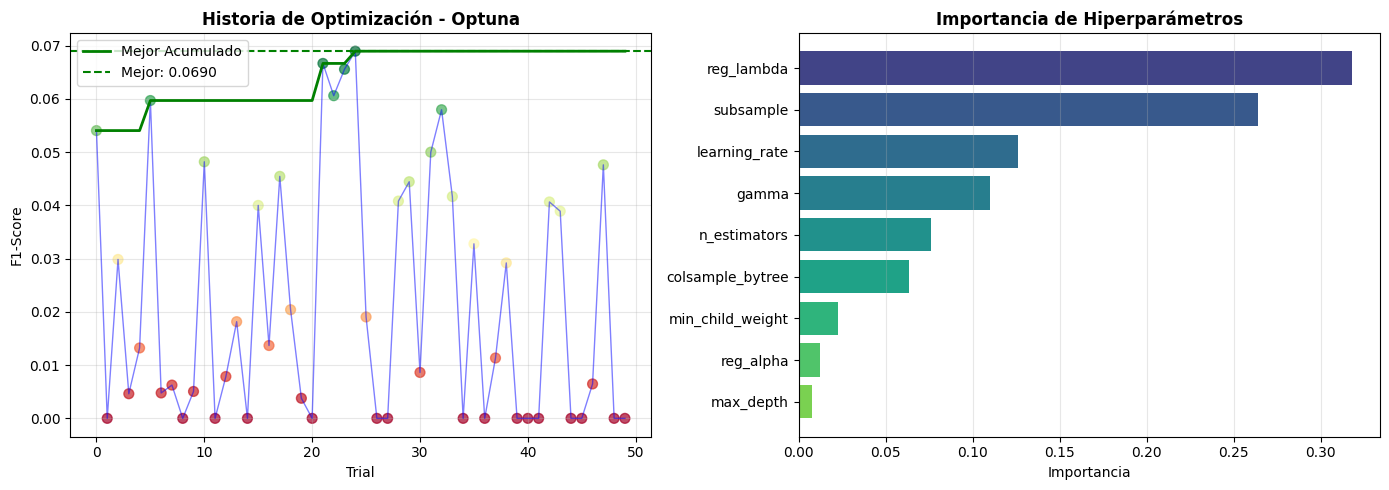


Resumen de Optimización:
  - Total de trials: 50
  - Mejor F1-Score: 0.0690
  - Trial del mejor resultado: 24


In [ ]:
# Historia de optimización de Optuna
Visualizer.plot_optuna_optimization_history(study)

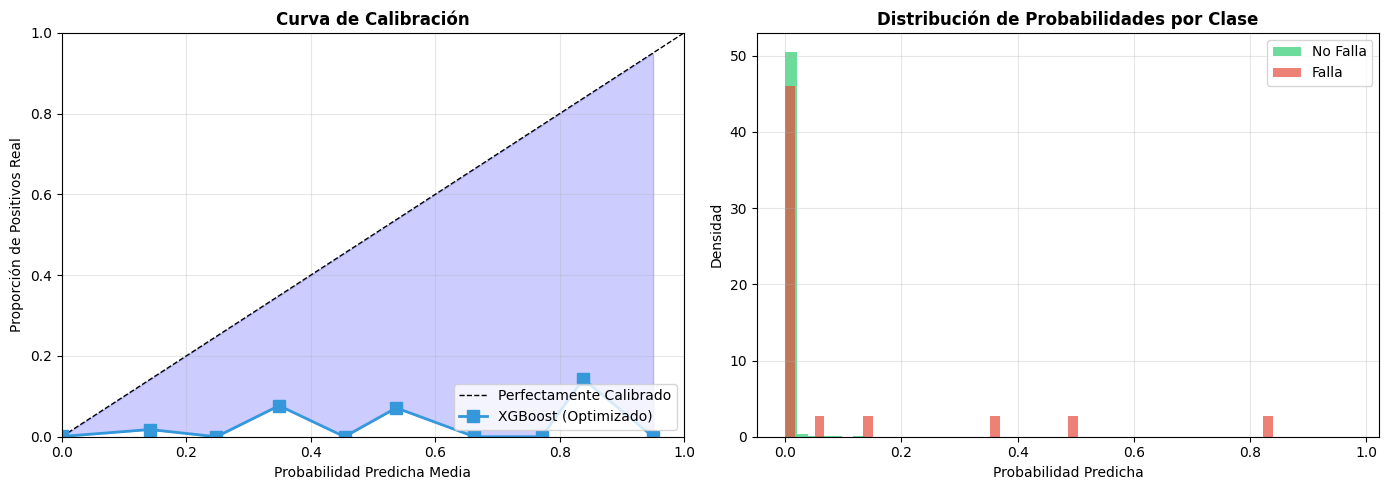


Métricas de Calibración:
  - Brier Score: 0.0019 (menor es mejor, 0 = perfecto)
  - Interpretación: Bien calibrado


In [ ]:
# Curva de calibración del modelo optimizado
Visualizer.plot_calibration_curve(y_test.values, best_model['y_pred_proba'], best_model_name)

In [ ]:
# Curvas de aprendizaje (opcional - puede tomar tiempo)
# Descomentar para ejecutar
# print("="*60)
# print("CURVAS DE APRENDIZAJE")
# print("="*60)
# Visualizer.plot_learning_curves(
#     model=best_model['model'],
#     X=X_train_balanced,
#     y=y_train_balanced,
#     model_name=best_model_name,
#     cv=3
# )

---
## 8. Optimización del Umbral de Decisión

In [ ]:
# Optimizar umbral de decisión
optimal_threshold, threshold_df = run_threshold_optimization(y_test, best_model['y_pred_proba'], baseline_cost)


📊 Optimización por: F1
   Umbral óptimo: 0.36
   Métricas en umbral óptimo:
     - F1:        0.0732
     - Recall:    0.1364
     - Precision: 0.0500
     - Costo:     $49.00

OPTIMIZACIÓN DEL UMBRAL

Umbral óptimo: 0.36
Costo con umbral óptimo: $49.00
Ahorro: $-27.00 (-122.73%)


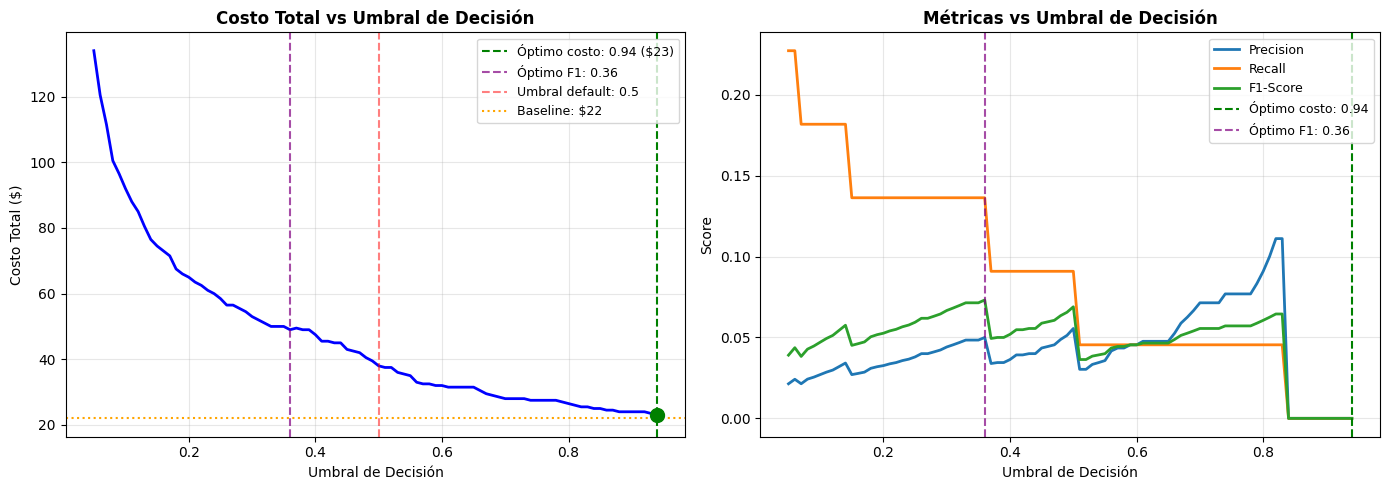


📊 Comparación de Umbrales Óptimos:
   Criterio        Umbral     Costo           F1        
   --------------------------------------------------
   Por Costo       0.94       $23             0.0000    
   Por F1          0.36       $49             0.0732    


In [ ]:
# Visualización de optimización de umbral
Visualizer.plot_threshold_optimization(threshold_df, optimal_threshold, baseline_cost)

---
## 9. Análisis Final del Mejor Modelo (Optimizado)

In [ ]:
# Predicciones finales con umbral óptimo
y_pred_final, final_cost = evaluate_final_model_performance(
    y_test, best_model['y_pred_proba'], optimal_threshold, baseline_cost, best_model_name
)


MODELO FINAL: XGBoost (Optimizado)
Umbral: 0.36

📊 MÉTRICAS:
              precision    recall  f1-score   support

    No Falla       1.00      1.00      1.00     23528
       Falla       0.05      0.14      0.07        22

    accuracy                           1.00     23550
   macro avg       0.52      0.57      0.54     23550
weighted avg       1.00      1.00      1.00     23550

📈 MATRIZ DE CONFUSIÓN:
                Predicho
                No Falla    Falla
Real No Falla     23,471        57
Real Falla            19         3

💰 ANÁLISIS DE COSTOS:
  - TN (óptimo):           23,471 → $0
  - FP (mant. innecesario): 57 → $28.50
  - FN (falla no prevenida): 19 → $19.00
  - TP (mant. previene):    3 → $1.50

  - Costo total:  $49.00
  - Baseline:     $22.00
  - AHORRO:       $-27.00 (-122.73%)


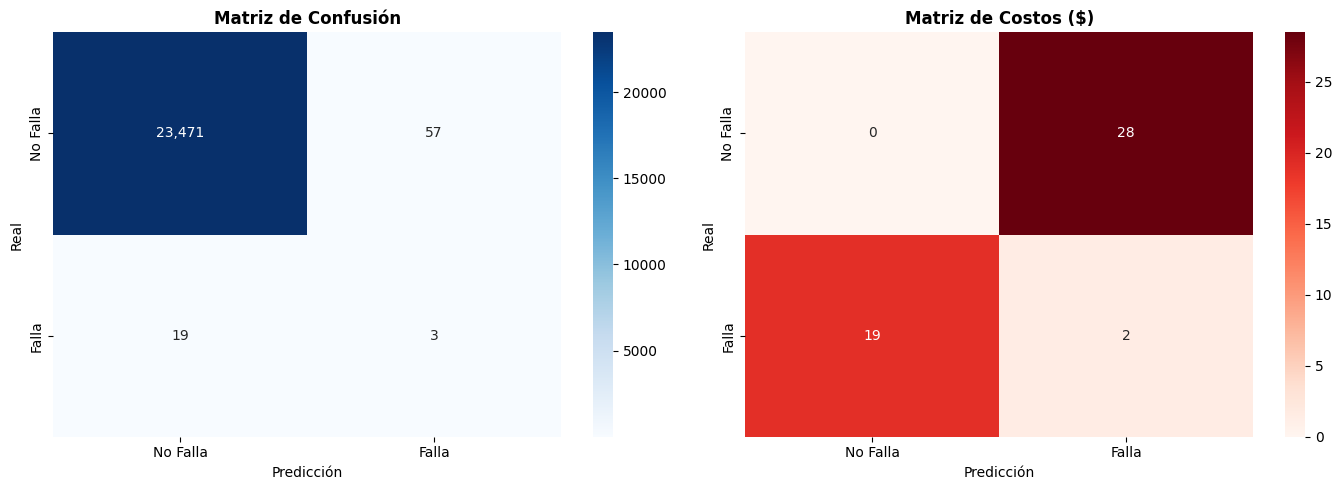

In [ ]:
# Matriz de confusión con costos
Visualizer.plot_confusion_matrix_with_costs(y_test, y_pred_final)

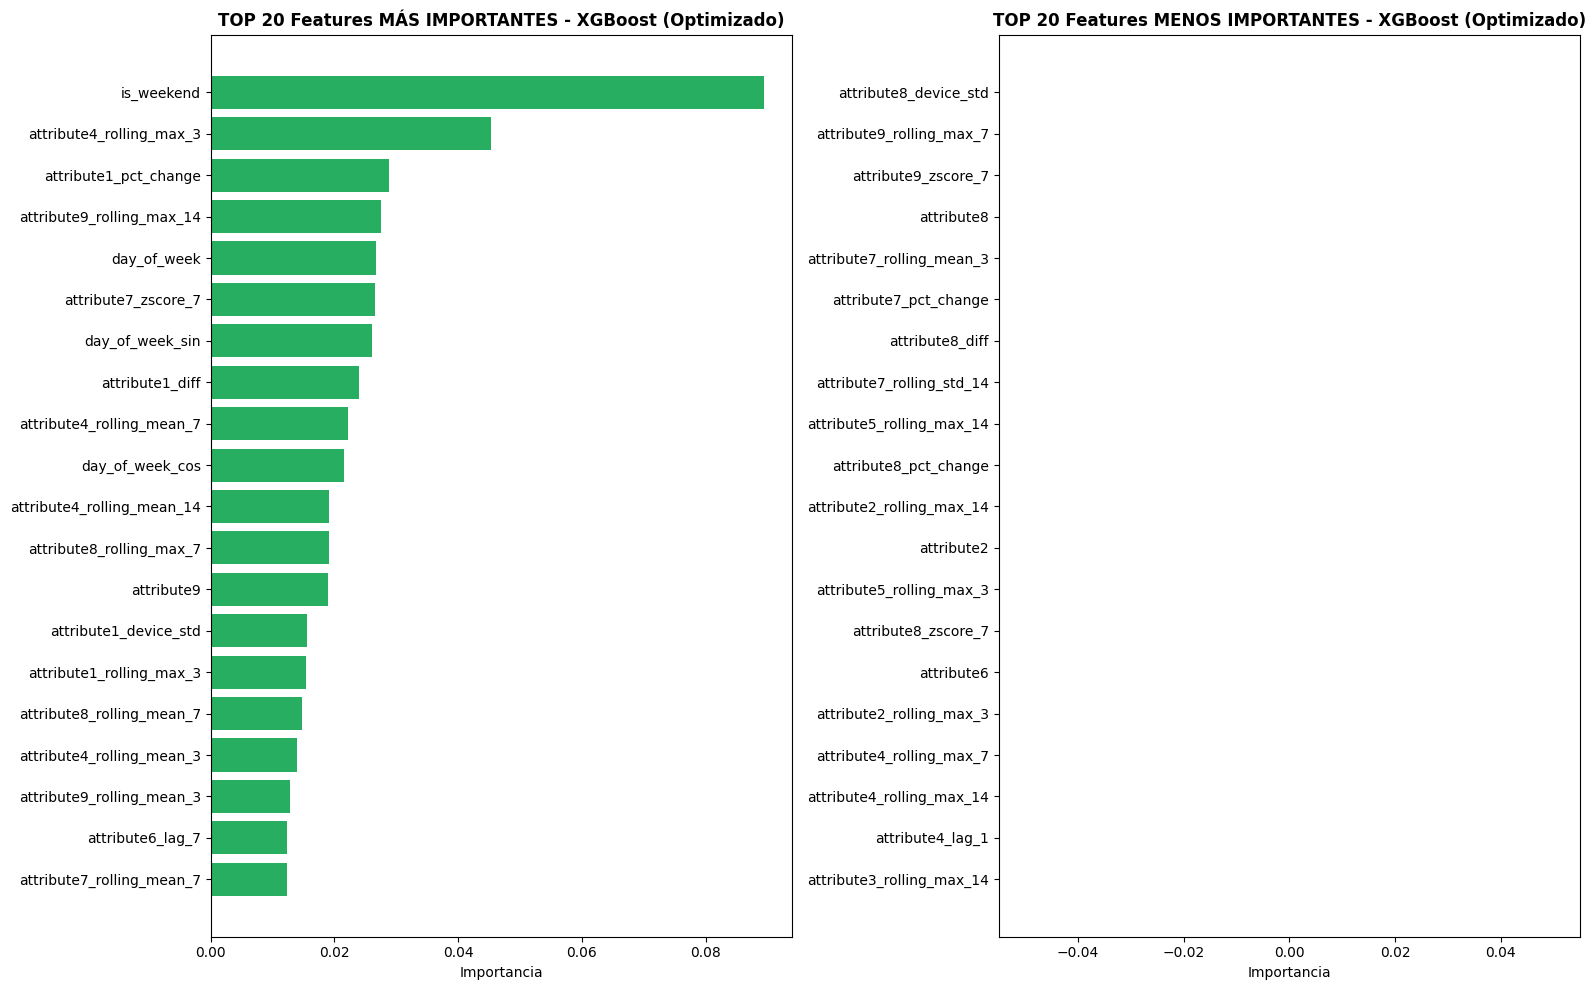

In [ ]:
# Feature Importance
Visualizer.plot_feature_importance(best_model['model'], data_prep.feature_cols, best_model_name)

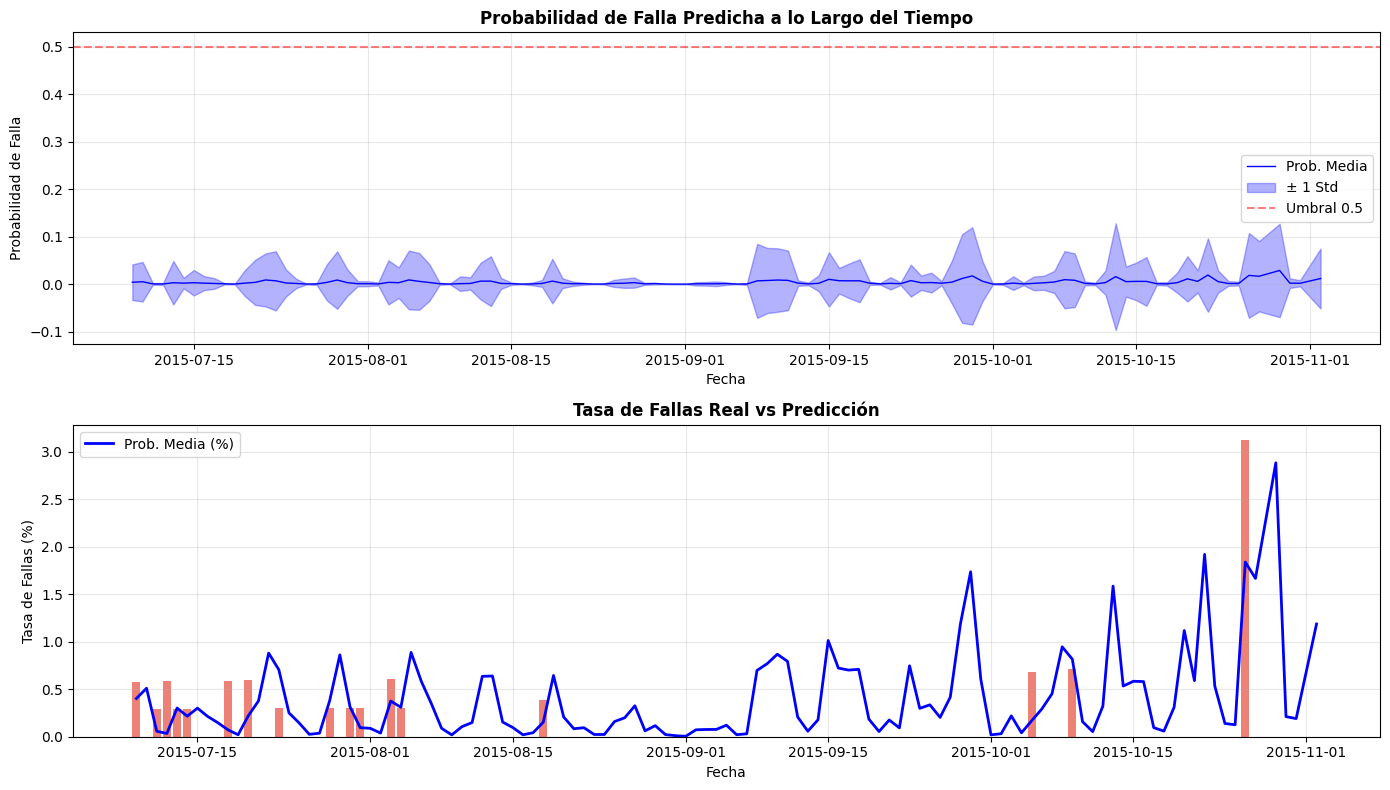

In [ ]:
# Predicciones a lo largo del tiempo
df_test = df_model[df_model['date'] >= split_date].copy()
Visualizer.plot_prediction_distribution_over_time(df_test, best_model['y_pred_proba'], y_test.values)

In [ ]:
# Guardar modelo
save_model_artifacts(best_model['model'], data_prep.scaler, data_prep.imputer, optimal_threshold, data_prep.feature_cols, best_model_name, study.best_params, study.best_value)

✅ Modelo guardado en 'predictive_maintenance_model_optimized.pkl'


---
## 9. Evaluación Final: ¿Vencemos los Benchmarks?

Comparación de costos acumulados entre:
1. **No hacer nada**: Cada falla nos cuesta $1.0
2. **Nuestro modelo**: Con el umbral óptimo y las predicciones finales
3. **Predicción perfecta**: El mejor escenario posible (mantener solo los que realmente fallan)

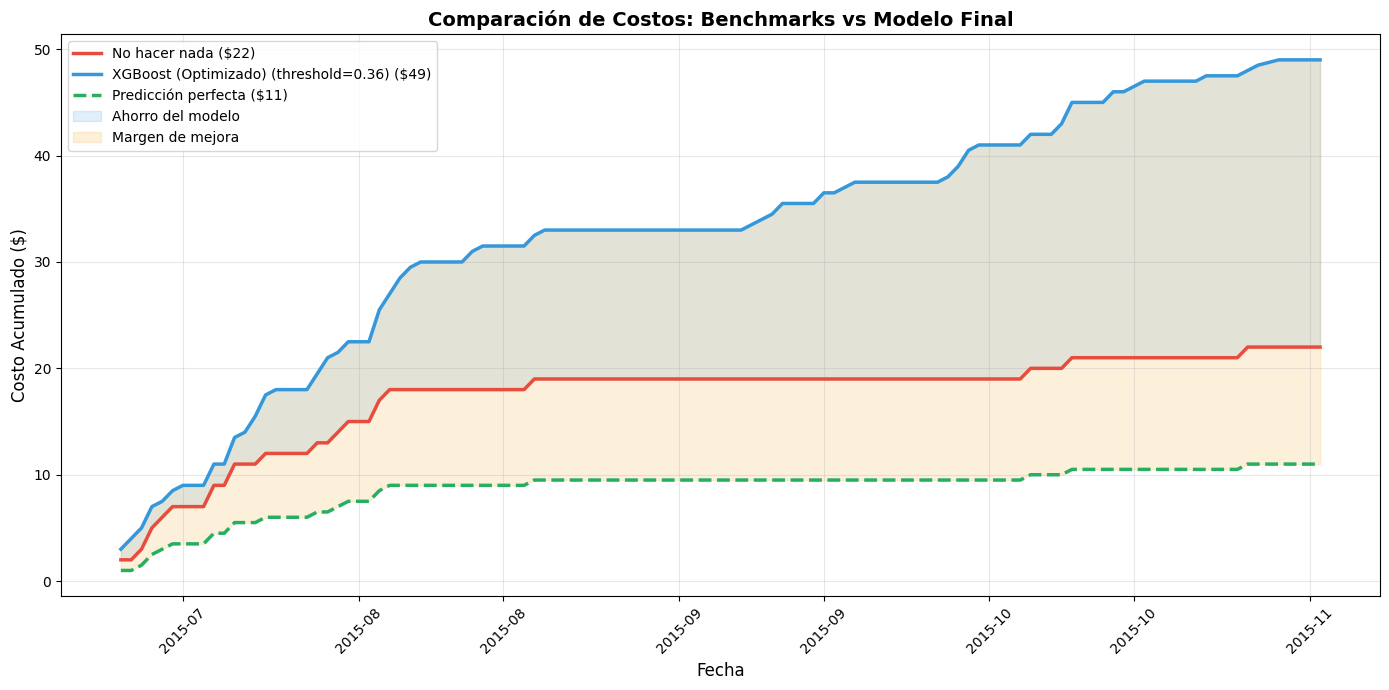


RESUMEN DE COSTOS - COMPARACIÓN DE ESCENARIOS

Dataset de test:
  - Total de registros: 23,550
  - Total de fallas: 22 (0.09%)

Costos totales:
  1. No hacer nada:        $22.00
  2. XGBoost (Optimizado) (threshold=0.36)    $49.00
  3. Predicción perfecta:  $11.00

Análisis de ahorro:
  - Ahorro del modelo vs no hacer nada: $-27.00 (-122.7%)
  - Ahorro máximo posible:              $11.00
  - Eficiencia del modelo:              -245.5% del ahorro máximo

❌ El modelo NO vence al benchmark 'No hacer nada'
⚠️  El modelo tiene margen de mejora significativo


In [ ]:
# Visualización final: Comparación de costos acumulados
# Benchmarks vs Modelo Final con umbral optimizado
plot_cost_over_time_with_model(
    df=df_test,
    y_pred=y_pred_final,
    y_true=y_test.values,
    date_col='date',
    model_name=f'{best_model_name} (threshold={optimal_threshold:.2f})'
)